# Lesson

## Import

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Code

In [ ]:
def compute_model(y_name, X_name, data):
    y = data.loc[:, y_name]
    X = sm.add_constant(data.loc[:, X_name].values)
    model = sm.OLS(y, X).fit()
    return show_table(model, X_name)

In [ ]:
def show_table(model, X_name):
    index_name = ['Intercept']

    if isinstance(X_name, str):
        index_name.append(X_name)
    elif isinstance(X_name, list):
        index_name = index_name + X_name

    df = pd.read_html(model.summary2().as_html())[1]
    colname = df.iloc[0]
    df = df.rename(columns=df.iloc[0]).drop(0).set_index(np.nan)
    df.index.name = None
    df.index = index_name

    return df

In [ ]:
def compute_VIF(columns, data):
    X = data.loc[:, columns]
    X.loc[:, 'Intercept'] = 1
      
    vif = pd.DataFrame()
    vif.loc[:, 'variables'] = X.columns
    vif.loc[:, 'VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
      
    return vif.drop(vif.tail(1).index)

In [ ]:
advertising = pd.read_csv('data/Advertising.csv')
credit = pd.read_csv('data/Credit.csv')

In [ ]:
# table 3.2
y = advertising['sales']
X = advertising[['TV']]
X = sm.add_constant(X)
slr = sm.OLS(y, X).fit()
rss = slr.resid.std(ddof=X.shape[1])
print(f'RSS: {rss}')
slr.summary().tables[0]

In [ ]:
# table 3.1
compute_model('sales', 'TV', advertising)

In [ ]:
# table 3.3
compute_model('sales', 'radio', advertising)

In [ ]:
# table 3.3
compute_model('sales', 'newspaper', advertising)

In [ ]:
# table 3.4
y = advertising['sales']
X = advertising[['TV', 'radio', 'newspaper']]
X = sm.add_constant(X)
mlr = sm.OLS(y, X).fit()
mlr.summary().tables[1]

In [ ]:
# table 3.6
y = advertising['sales']
X = advertising[['TV', 'radio', 'newspaper']]
X = sm.add_constant(X)
mlr = sm.OLS(y, X).fit()
rss = mlr.resid.std(ddof=X.shape[1])
print(f'RSS: {rss}')
mlr.summary().tables[0]

In [ ]:
# table 3.7
credit_owner_dummy = pd.get_dummies(credit, columns=['Own'])
compute_model('Balance', 'Own_Yes', credit_owner_dummy)

In [ ]:
# table 3.8
credit_region_dummy = pd.get_dummies(credit, columns=['Region'])
compute_model('Balance', ['Region_West', 'Region_South'], credit_region_dummy)

In [ ]:
# table 3.9
advertising['TVxradio'] = advertising['TV'] * advertising['radio']
compute_model('sales', ['TV', 'radio', 'TVxradio'], advertising)

In [ ]:
# table 3.11
groupby_cols = ['model', 'column']

model_1_df = compute_model('Balance', ['Age', 'Limit'], credit)
model_1_df['model'] = 'Model 1'
model_2_df = compute_model('Balance', ['Rating', 'Limit'], credit)
model_2_df['model'] = 'Model 2'

model_df = pd.concat([model_1_df, model_2_df]).reset_index()
model_df.rename(columns = {'index': 'column'}, inplace=True)
model_df = model_df.groupby(groupby_cols, group_keys=True).apply(lambda a: a[:])
model_df[model_df.columns.drop(groupby_cols)]

In [ ]:
compute_VIF(['TV', 'radio', 'newspaper'], advertising)

# Lab

## Import

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

from ISLP import load_data
from ISLP.models import ModelSpec as MS, summarize, poly

In [46]:
plt.rcParams['font.family'] = 'Avenir'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 300

In [47]:
IMG_EXPORT_CONFIG = {
    'dpi': 500,
    'bbox_inches': 'tight',
    'pad_inches': 0.15,
}

In [48]:
sns.set_theme(style='whitegrid')
sns.set_palette('hls', 8)

## Code

The `boston` dataset records `medv` (median house value) for 506 neighborhoods around Boston. 

We will build a regression model to predict `medv` using **13** predictors such as:
- `rmvar` (average number of rooms per house),
- `age` (proportion of owner-occupied units built prior to 1940), and
- `lstat` (percent of households with low socioeconomic status).

In [49]:
boston_df = load_data('Boston')
boston_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [50]:
boston_df?

Type:        DataFrame
String form:
crim    zn  indus  chas    nox     rm   age     dis  rad  tax  \
           0    0.00632  18.0   2.3 <...> 0   5.64  23.9
           504     21.0   6.48  22.0
           505     21.0   7.88  11.9
           
           [506 rows x 13 columns]
Length:      506
File:        /opt/homebrew/lib/python3.10/site-packages/pandas/core/frame.py
Docstring:  
Two-dimensional, size-mutable, potentially heterogeneous tabular data.

Data structure also contains labeled axes (rows and columns).
Arithmetic operations align on both row and column labels. Can be
thought of as a dict-like container for Series objects. The primary
pandas data structure.

Parameters
----------
data : ndarray (structured or homogeneous), Iterable, dict, or DataFrame
    Dict can contain Series, arrays, constants, dataclass or list-like objects. If
    data is a dict, column order follows insertion-order. If a dict contains Series
    which have an index defined, it is aligned by its index.

### Simple Linear Regression

Our response will be `medv` and `lstat` will be the single predictor.

In [51]:
X = pd.DataFrame({
    'intercept': np.ones(boston_df.shape[0]),
    'lstat': boston_df['lstat'],
})
X.head()

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33


`sm.OLS()` does not fit the model, rather it specifies the model, and then `model.fit()` does the actual fitting.

In [52]:
y = boston_df['medv']
slr = sm.OLS(y, X)
slr_result = slr.fit()

In [53]:
summarize(slr_result)

,coef,std err,t,P>|t|
intercept,34.5538,0.563,61.415,0.0
lstat,-0.9500,0.039,-24.528,0.0


In [54]:
slr_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Sun, 24 Dec 2023   Prob (F-statistic):           5.08e-88
Time:                        15:32:45   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.5538      0.563     61.415      0.000      33.448      35.659
lstat         -0.9500      0.039    -24.528      0.000      -1.026      -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
slr_result.params

intercept    34.553841
lstat        -0.950049
dtype: float64

#### Using Transformations: Fit and Transform

`ModelSpec()` (renamed `MS()` in the preamble) creates a transform object, and then a pair of methods `transform()` and `fit()` are used to construct a corresponding model matrix.

In this simple case, the `fit()` method does very little; it simply checks that the variable `lstat` specified in design exists in `boston`. Then `transform()` constructs the model matrix with two columns: an intercept and the variable `lstat`.

These two operations can be combined with the `fit_transform() `method.

In [69]:
design = MS(['lstat'])
# option 1
design = design.fit(boston_df)
X = design.transform(boston_df)
# option 2
X = design.fit_transform(boston_df)
X.head()

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33


The `get_prediction()` method can be used to obtain predictions, and produce confidence intervals and prediction intervals for the prediction of `medv` for given values of `lstat`.

In [70]:
new_df = pd.DataFrame({'lstat': [5, 10, 15]})
new_X = design.transform(new_df)
new_X

,intercept,lstat
0,1.0,5
1,1.0,10
2,1.0,15


In [71]:
new_pred = slr_result.get_prediction(new_X)
new_pred.predicted_mean

array([29.80359411, 25.05334734, 20.30310057])

In [72]:
# confidence interval
new_pred.conf_int(alpha=0.05)

array([[29.00741194, 30.59977628],
       [24.47413202, 25.63256267],
       [19.73158815, 20.87461299]])

In [73]:
# prediction internal
new_pred.conf_int(obs=True, alpha=0.05)

array([[17.56567478, 42.04151344],
       [12.82762635, 37.27906833],
       [ 8.0777421 , 32.52845905]])

The 95% confidence interval associated with an `lstat` value of 10 is (24.47, 25.63), and the 95% prediction interval is (12.82, 37.28).

#### Defining Functions

In [74]:
def add_linear_line(ax, m, b, *args, **kwargs):
    """ Add a line with slope m and intercept b to ax """
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

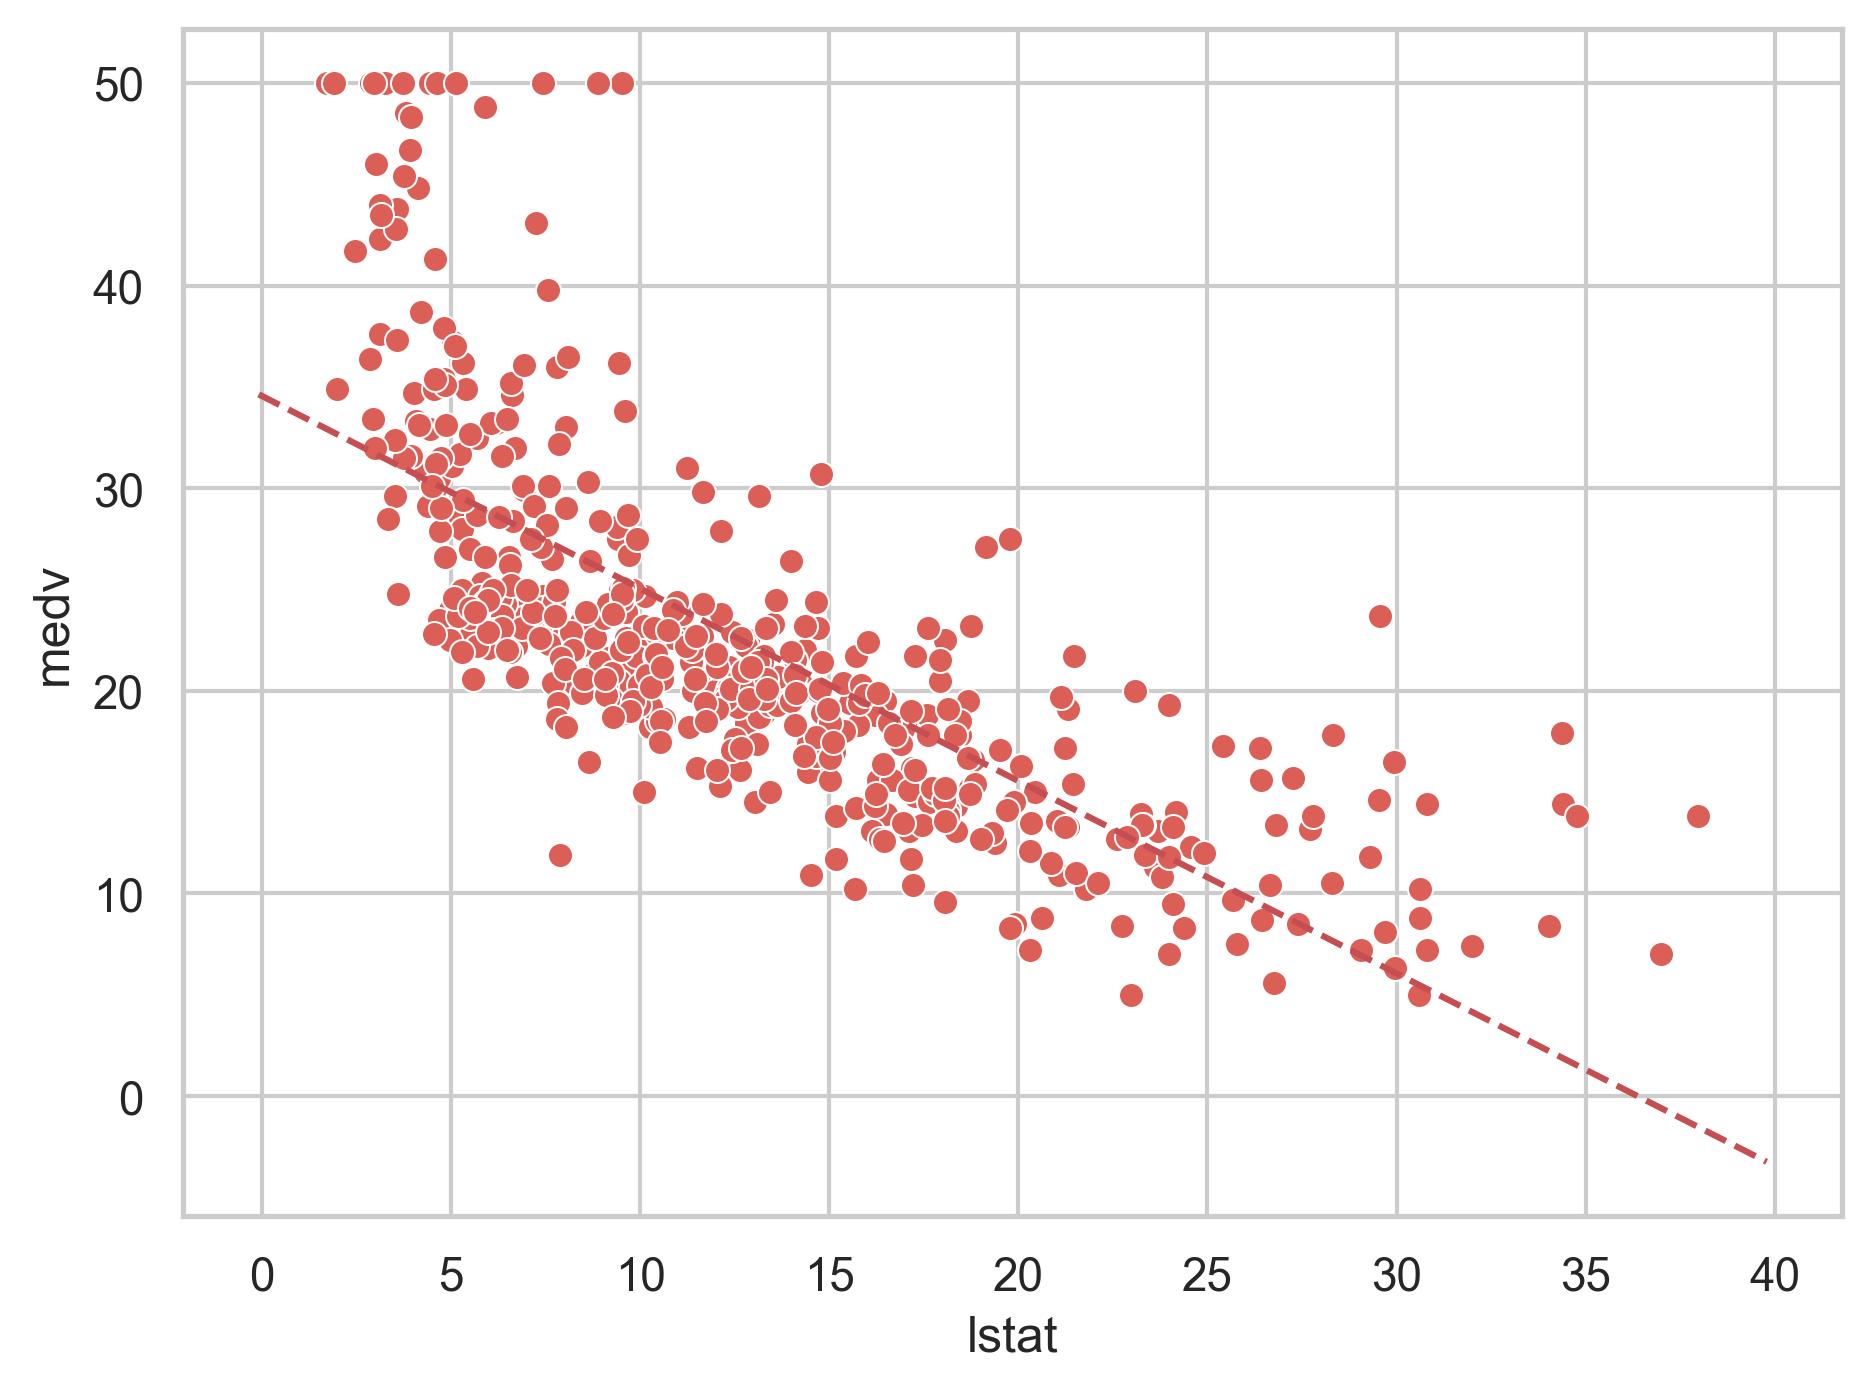

In [82]:
fig, ax = plt.subplots()
sns.scatterplot(x='lstat', y='medv', data=boston_df, ax=ax)
add_linear_line(ax, slr_result.params[1], slr_result.params[0], 'r--')
fig.tight_layout()

We plot the fitted values (`.fittedvalues`) against theirs residuals (`.resid`). We add a horizontal line at `0` for reference using the `ax.axhline()` method, indicating it should be black (`c='k'`) and have a dashed linestyle (`ls='--'`).

From the plot, there is some evidence of non-linearity.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(slr_result.fittedvalues, slr_result.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')
fig.tight_layout()

Various influence measures describing the regression model are computed with the `get_influence()` method.

Leverage statistics can be computed for any number of predictors using the `hat_matrix_diag` attribute of the value returned by the `get_influence()` method.

The `np.argmax()` function identifies the index of the largest element of an array, optionally computed over an axis of the array.

In [ ]:
influence = slr_result.get_influence()
influence.summary_frame()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(np.arange(X.shape[0]), influence.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(influence.hat_matrix_diag)
fig.tight_layout()

### Multiple Linear Regression

In order to fit a multiple linear regression model using least squares, we again use the `ModelSpec()` transform to construct the required model matrix and response.

In [ ]:
X = MS(['lstat', 'age']).fit_transform(boston_df)
mlr = sm.OLS(y, X)
mlr_result = mlr.fit()
summarize(mlr_result)

Now, we will use all columns to predict `medv`.

In [ ]:
terms = boston_df.columns.drop('medv')
terms

In [ ]:
new_X = MS(terms).fit_transform(boston_df)
new_mlr = sm.OLS(y, new_X)
new_mlr_result = mlr.fit()
summarize(new_mlr_result)

From the summarize, we see that `indus` and `age` has high $p$-value. So we'd remove these 2 columns from the prediction.

In [ ]:
new_terms = boston_df.columns.drop(['medv', 'indus', 'age'])
new_X = MS(new_terms).fit_transform(boston_df)
new_mlr = sm.OLS(y, new_X)
new_mlr_result = new_mlr.fit()
summarize(new_mlr_result)

### Multivariate Goodness of Fit

#### List Comprehension

**Variance Inflation Factor (VIF):** is the ratio of the variance of $\hat\beta_j$ when fitting the full model divided by the variance of $\hat\beta_j$ if fit on its own.

Function `VIF()` takes 2 arguments: a dataframe or array, and a variable column index.

In [ ]:
vals = [VIF(X, i) for i in range(1, X.shape[1])]
vif = pd.DataFrame({'vif': vals}, index=X.columns[1:])
vif

### Interaction Terms

**Interaction Term:** constructed by computing the product of $X_1$ and $X_2$.

⟹ Extended model: $$Y = \beta_0 + \beta_1X1 + \beta_2X_2 + \beta_3X_1X_2 + \epsilon$$

Including a tuple `('lstat', 'age')` tells the model matrix builder to include an interaction term between `lstat` and `age`.

In [ ]:
X_2 = MS(['lstat', 'age', ('lstat', 'age')]).fit_transform(boston_df)
mlr_2 = sm.OLS(y, X_2)
mlr_result_2 = mlr_2.fit()
summarize(mlr_result_2)

### Non-linear Transformations of the Predictors

Function `poly()` supplied in `ISLP` creates a basis matrix for inclusion in the model matrix whose columns are *orthogonal polynomials*, which are designed for stable least squares computations.

It specifies that columns representing polynomial functions of its first argument are added to the model matrix.

In [ ]:
X_3 = MS(terms=[poly(col='lstat', degree=2), 'age']).fit_transform(boston_df)
mlr_3 = sm.OLS(y, X_3)
mlr_result_3 = mlr_3.fit()
summarize(mlr_result_3)

The zero $p$-value associated with the quadratic term (`poly(lstat, degree=2)[1]`) suggests that this is an improved model.

The `anova_lm` function performs a hypothesis test comparing the 2 models.
- $H_0$: quadratic term in the bigger model is not need
- $H_a$: the bigger model is superior

In [ ]:
anova_lm(mlr_result, mlr_result_3)

Here, the $F$-statistic os 177.28 and the associated $p$-value is zero. The $F$-statistic is the square of the $t$-statistic for the quadratic term in the linear model summary for `mlr_result_3` -- a consequence of the fact that these nested models differ by 1 degree of freedom.

⟹ Reject null hypothesis.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=pd.DataFrame({
    'fittedvalues': mlr_result_3.fittedvalues,
    'resid': mlr_result_3.resid,
}), x='fittedvalues', y='resid')
ax.set_xlabel('Fitted Value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')
fig.tight_layout()

### Qualitative Predictors

`Carseats` dataset includes qualitative predictors such as `ShelveLoc`, an indicator of the quality of the shelving location, and takes 3 values `Bad`, `Medium`, and `Good`.

In [ ]:
carseats_df = load_data('Carseats')
carseats_df.head()

The model-matrix builder has created:
- `ShelveLoc[Good]` dummy variable that takes on a value of 1 if the shelving location is `good`, and 0 otherwise
- `ShelveLoc[Medium]` dummy variable that equals 1 if the shelving location is `medium`, and 0 otherwise

In [ ]:
terms = list(carseats_df.columns.drop('Sales'))
terms += [('Income', 'Advertising'), ('Price', 'Age')]
y = carseats_df['Sales']
X = MS(terms).fit_transform(carseats_df)
mlr = sm.OLS(y, X)
mlr_result = mlr.fit()
summarize(mlr_result)

The coefficient for `ShelveLoc[Good]` > 0 indicates that a `good` shelving location is associated with high sales (relative to a bad location). And `ShelveLoc[Medium]` has a smaller positive coefficient, indicating that a `medium` shelving location leads to lower sales than a `good` shelving location and higher sales than a `bad` shelving location.

# Applied

## Import

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

from ISLP import load_data
from ISLP.models import ModelSpec as MS, summarize, poly

In [124]:
plt.rcParams['font.family'] = 'Avenir'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 300

In [125]:
IMG_EXPORT_CONFIG = {
    'dpi': 500,
    'bbox_inches': 'tight',
    'pad_inches': 0.15,
}

In [126]:
sns.set_theme(style='whitegrid')
sns.set_palette('hls', 8)

## Code

In [36]:
def compute_model(y_name, X_name, data):
    y = data.loc[:, y_name]
    X = sm.add_constant(data.loc[:, X_name].values)
    model = sm.OLS(y, X).fit()
    
    return model, show_table(model, X_name)

In [33]:
def show_table(model, X_name):
    index_name = ['Intercept']
    if isinstance(X_name, str):
        index_name.append(X_name)
    elif isinstance(X_name, list):
        index_name = index_name + X_name
    
    df = pd.read_html(model.summary2().as_html())[1]
    colname = df.iloc[0]
    df = df.rename(columns=df.iloc[0]).drop(0).set_index(np.nan)
    df.index.name = None
    df.index = index_name
    
    return df

### Exercise 8 / 129

(a) Use the `sm.OLS()` function to perform a simple linear regression with `mpg` as the response and `horsepower` as the predictor. Use the `summarize()` function to print the results. Comment on the output. For example:

1. Is there a relationship between the predictor and the response?
2. How strong is the relationship between the predictor and the response?
3. Is the relationship between the predictor and the response positive or negative?
4. What is the predicted `mpg` associated with a `horsepower` of 98? What are the associated 95% confidence and prediction intervals?

In [85]:
auto_df = pd.read_csv('data/Auto.csv')
auto_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [86]:
slr_df = pd.DataFrame({
    'mpg': pd.to_numeric(auto_df['mpg'], errors='coerce'),
    'horsepower': pd.to_numeric(auto_df['horsepower'], errors='coerce'),
}).dropna()
slr_result, slr_summary = compute_model('mpg', 'horsepower', slr_df)
slr_summary

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,39.9359,0.7175,55.6598,0.0000,38.5252,41.3465
horsepower,-0.1578,0.0064,-24.4891,0.0000,-0.1705,-0.1452


In [87]:
slr_result.summary().tables[0]

Dep. Variable:,mpg,R-squared:,0.606
Model:,OLS,Adj. R-squared:,0.605
Method:,Least Squares,F-statistic:,599.7
Date:,"Sun, 24 Dec 2023",Prob (F-statistic):,7.03e-81
Time:,16:15:05,Log-Likelihood:,-1178.7
No. Observations:,392,AIC:,2361.
Df Residuals:,390,BIC:,2369.
Df Model:,1,,
Covariance Type:,nonrobust,,


In [88]:
design = MS(['horsepower'])
X = design.fit_transform(slr_df)
new_df = pd.DataFrame({'horsepower': [98]})
new_X = design.transform(new_df)
new_pred = slr_result.get_prediction(new_X)
print(f'Confidence Interval: {new_pred.conf_int(alpha=0.05)}')
print(f'Prediction Interval: {new_pred.conf_int(obs=True, alpha=0.05)}')

Confidence Interval: [[23.97307896 24.96107534]]
Prediction Interval: [[14.80939607 34.12475823]]


1. The small $p$-values indicates that there is a statistically significant relationship between the `horsepower` and `mpg`.
2. From the 2nd table, we see that `horsepower` explains 60.6% of the variance in `mpg`.
3. We can see that the coefficient of `horsepower` is a negative number, hence, the relationship between `horsepower` and `mpg` is negative.
4. The predicted `mpg` associated with a `horsepower` of 98 is: $= 39.9359 + 98 \times (-0.1578) = 24.4715$. <br>
    The 95% confidence interval is [-65.0684 -52.0335] and that of predicted interval is [-72.3933, -44.7087].

(b) Plot the response and the predictor in a new set of axes `ax`. Use the `ax.axline()` method or the `abline()` function defined in the lab to display the least squares regression line.

In [89]:
def add_linear_line(ax, m, b, *args, **kwargs):
    """ Add a line with slope m and intercept b to ax """
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

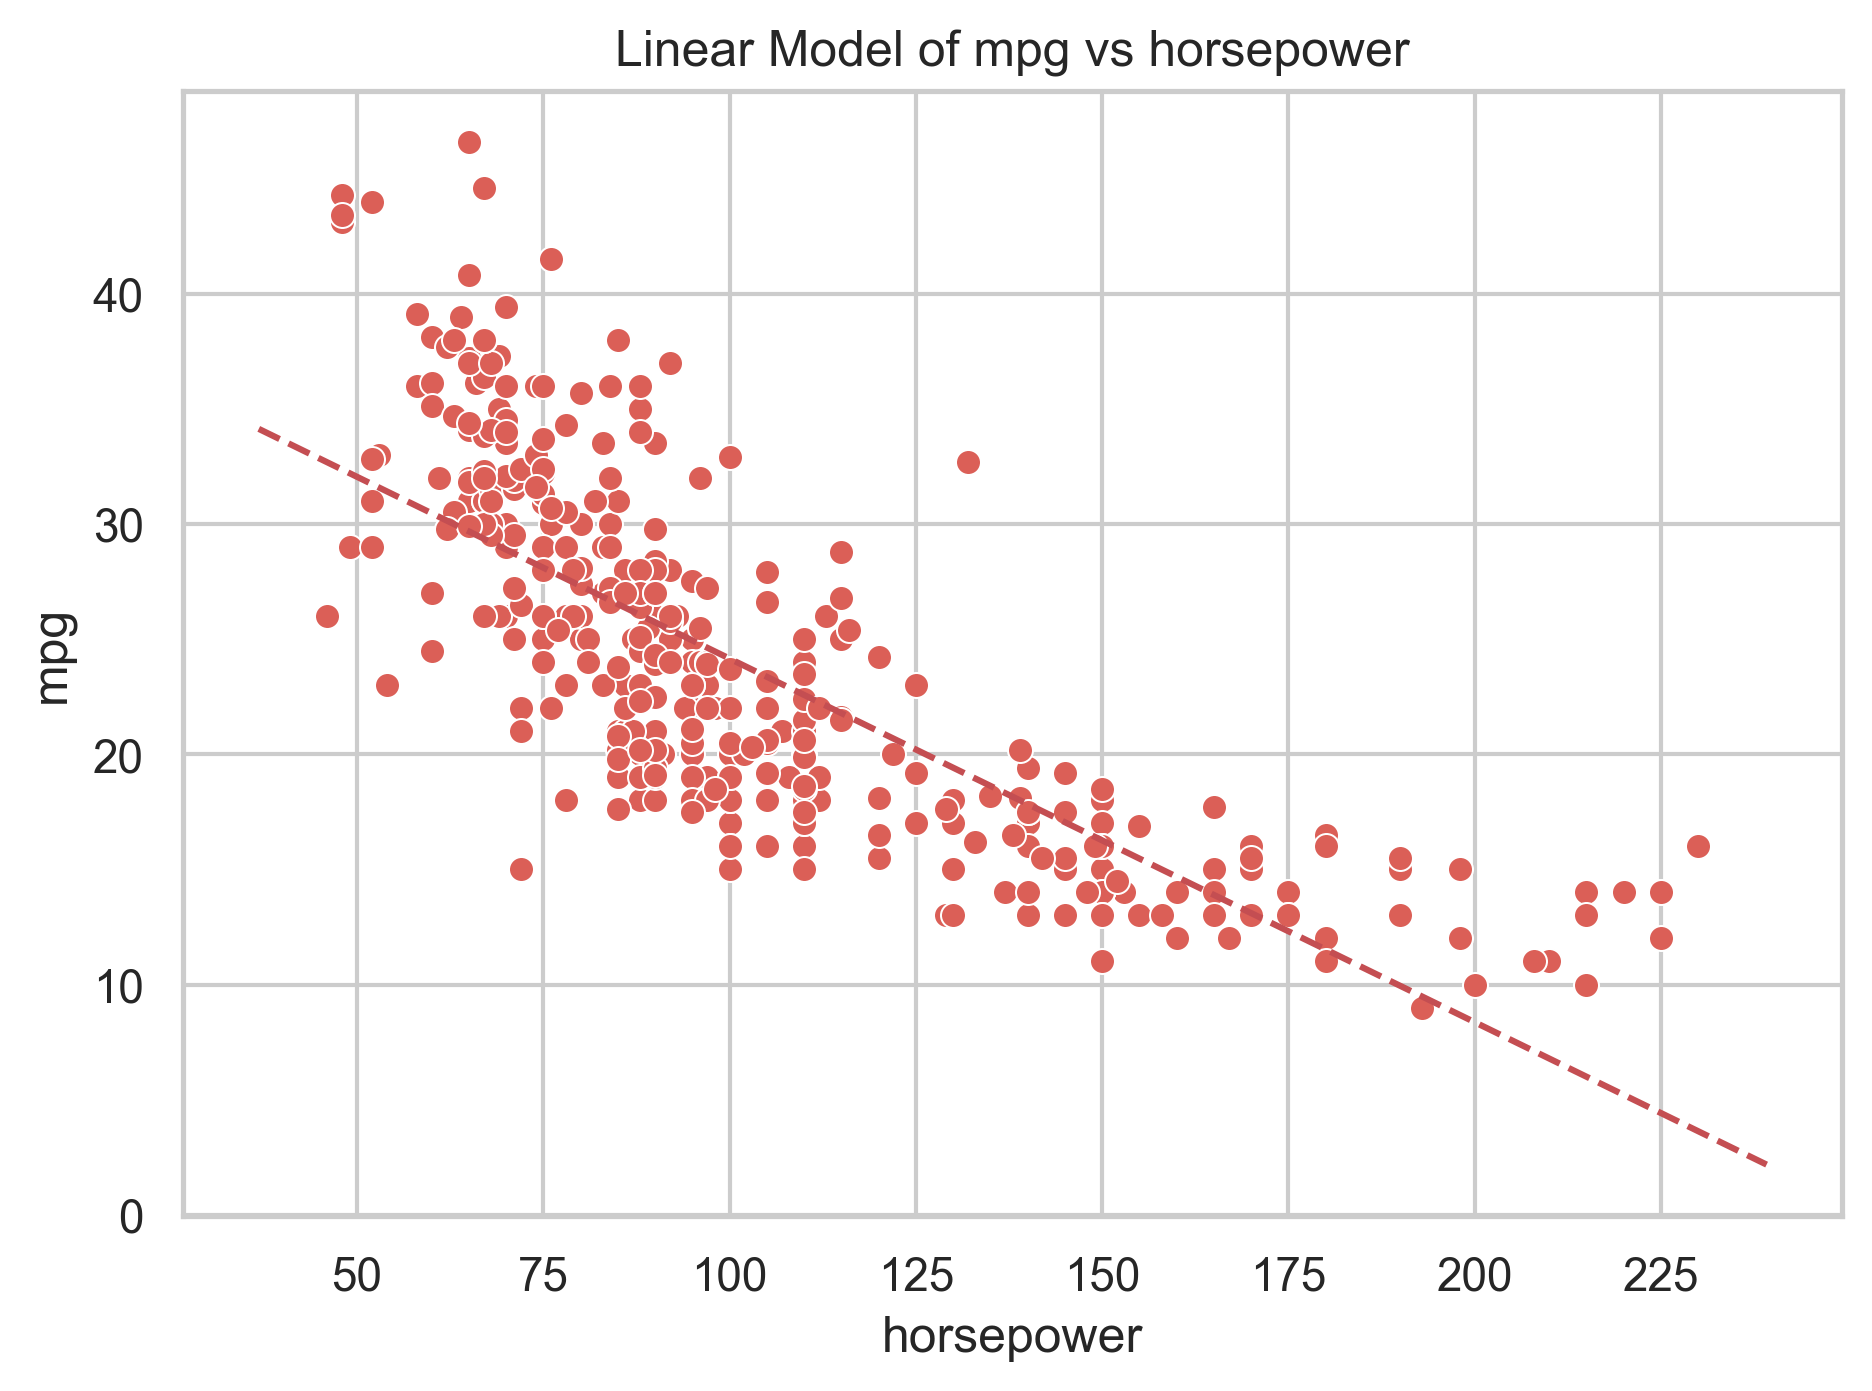

In [95]:
fig, ax = plt.subplots()
sns.scatterplot(x='horsepower', y='mpg', data=slr_df, ax=ax)
add_linear_line(ax, slr_result.params[1], slr_result.params[0], 'r--')
ax.set_title('Linear Model of mpg vs horsepower')
fig.tight_layout()

(c) Produce some of diagnostic plots of the least squares regression fit as described in the lab. Comment on any problems you see with the fit.

In [129]:
fitted_values = slr_result.fittedvalues
resid = slr_result.resid
student_resid = slr_result.outlier_test()['student_resid']
leverage_resid = slr_result.get_influence().hat_matrix_diag

In [136]:
auto_1_df = pd.DataFrame({
    'fittedvalues': fitted_values,
    'resid': resid,
})
auto_2_df = pd.DataFrame({
    'fittedvalues': fitted_values,
    'sqrt_student_resid': np.sqrt(np.abs(student_resid)),
})
auto_3_df = pd.DataFrame({
    'leverage': leverage_resid,
    'student_resid': student_resid,
})

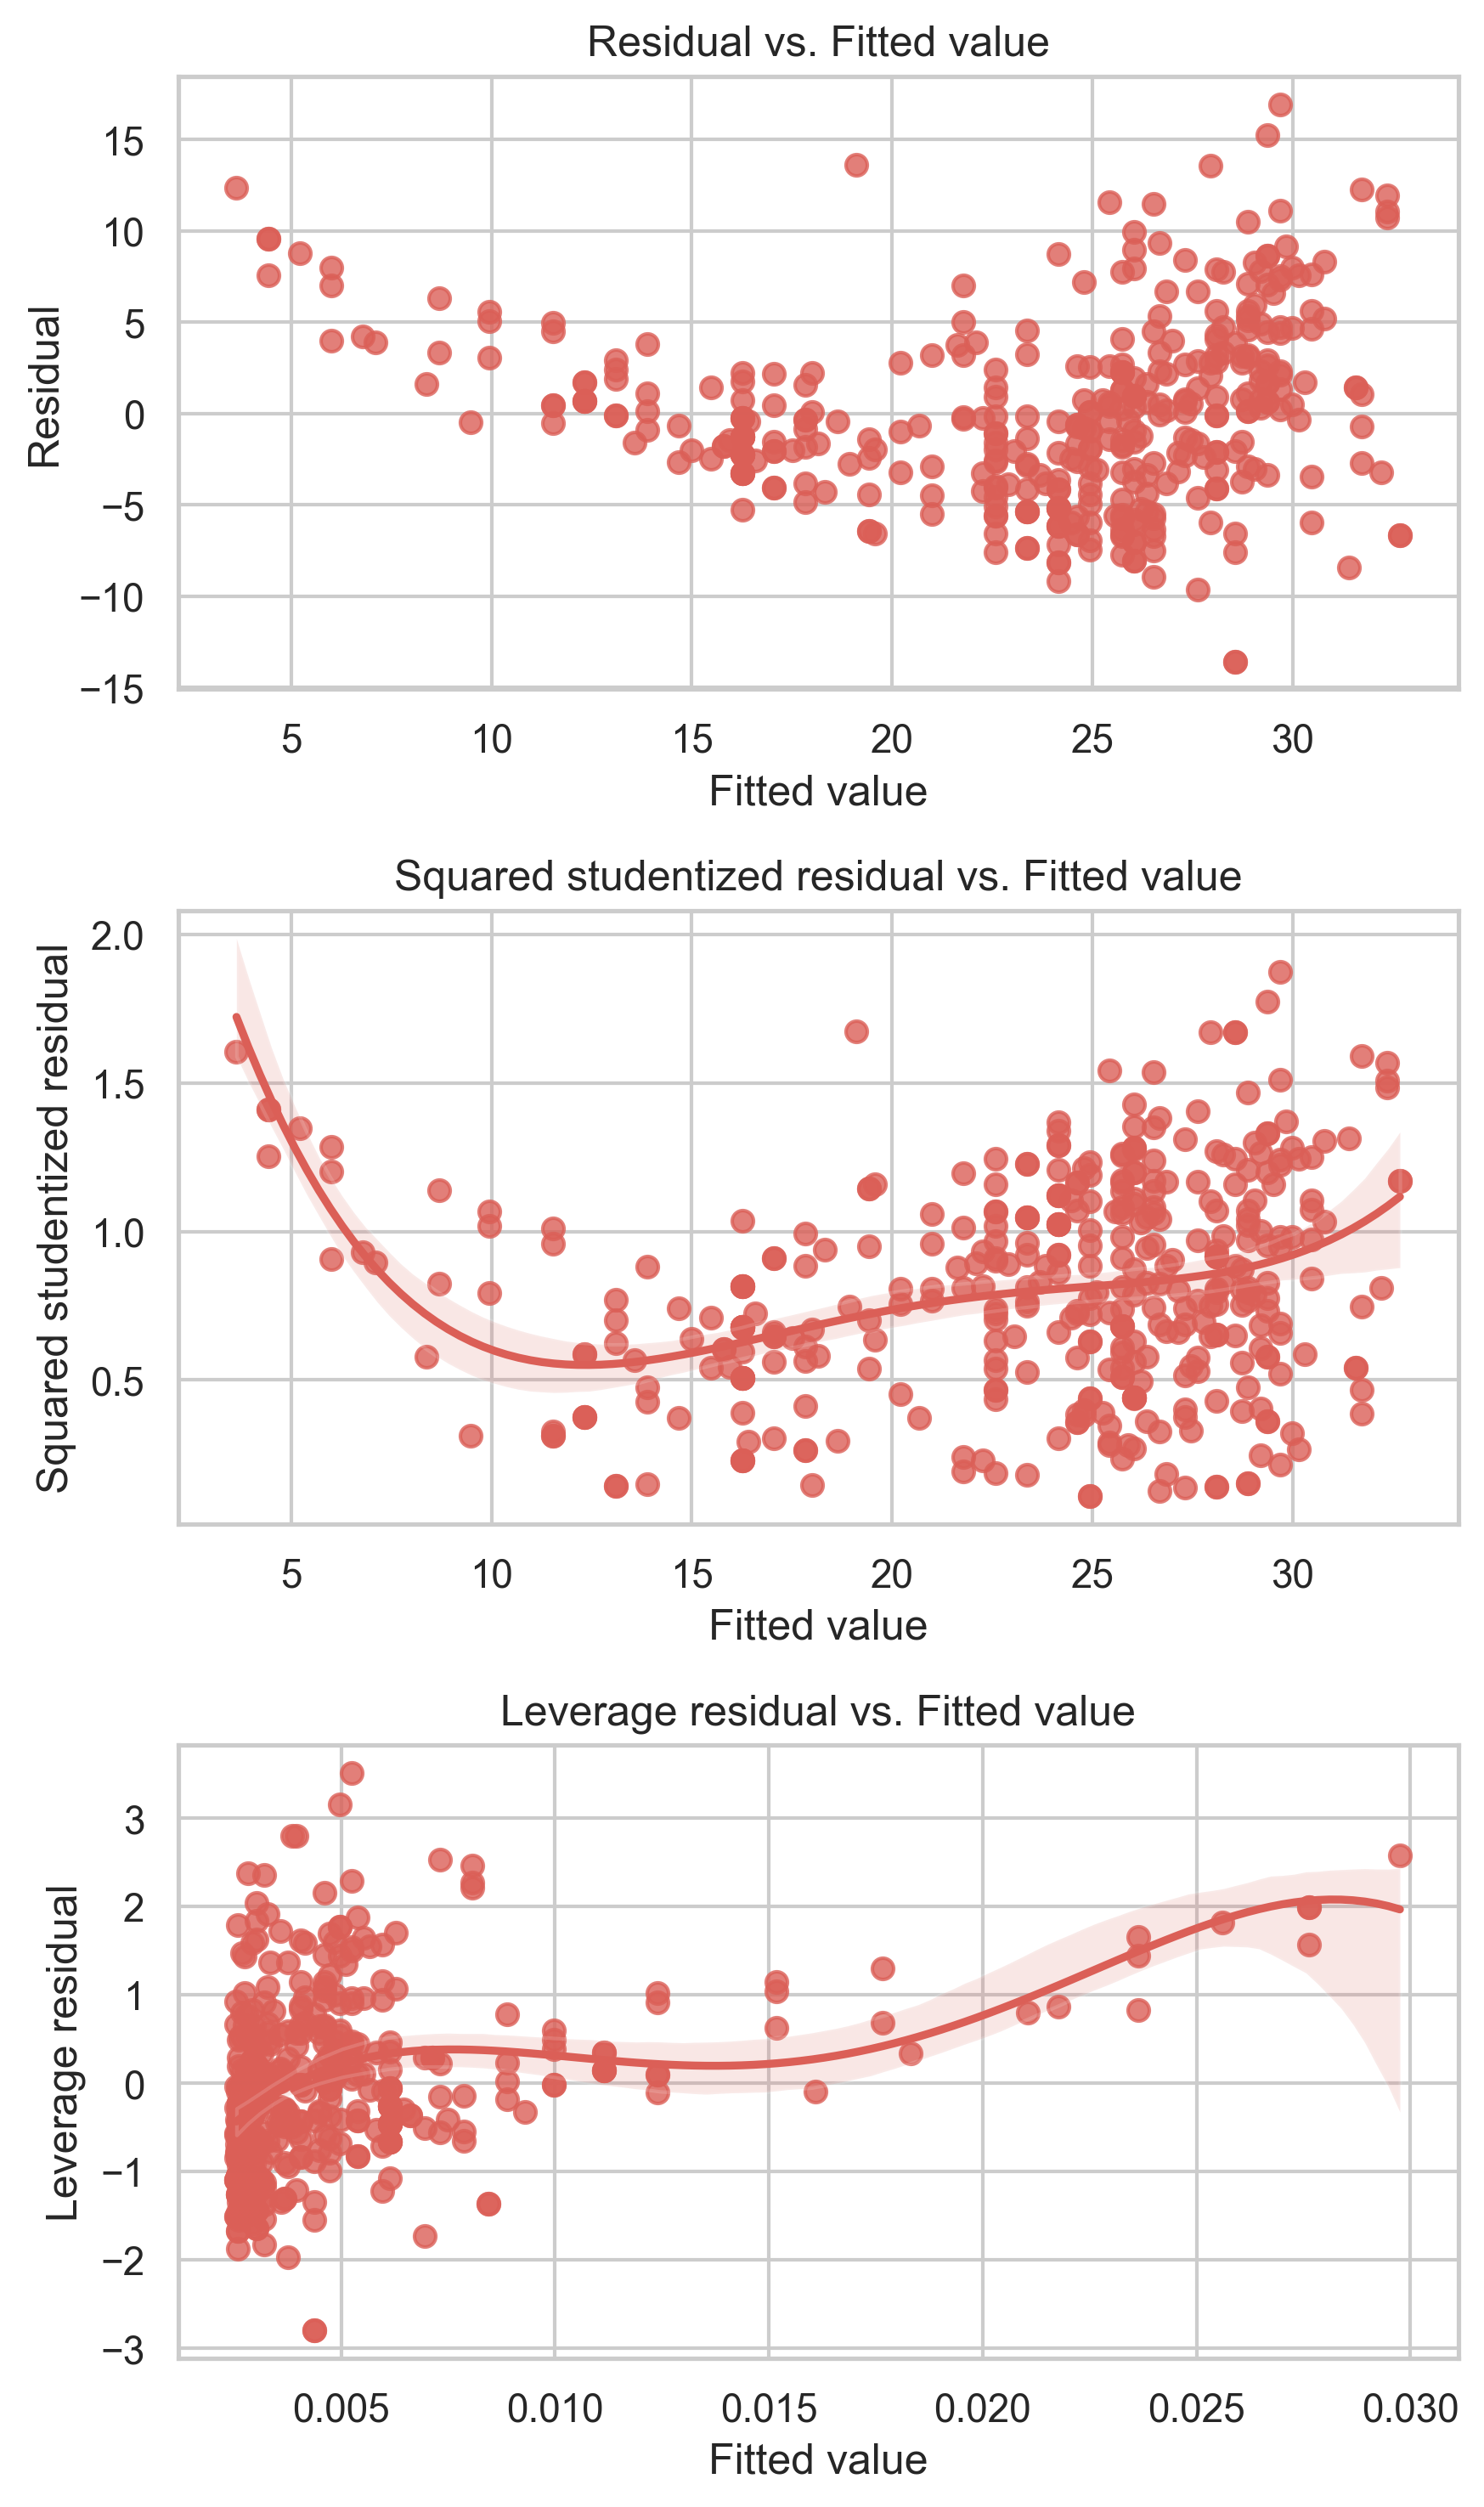

In [151]:
fig, axes = plt.subplots(3, 1, figsize=(6, 10))

sns.regplot(data=auto_1_df, x='fittedvalues', y='resid', order=4, marker ax=axes[0])
axes[0].set_xlabel('Fitted value')
axes[0].set_ylabel('Residual')
axes[0].set_title('Residual vs. Fitted value')

sns.regplot(data=auto_2_df, x='fittedvalues', y='sqrt_student_resid', order=4, ax=axes[1])
axes[1].set_xlabel('Fitted value')
axes[1].set_ylabel('Squared studentized residual')
axes[1].set_title('Squared studentized residual vs. Fitted value')

sns.regplot(data=auto_3_df, x='leverage', y='student_resid', order=4, ax=axes[2])
axes[2].set_xlabel('Fitted value')
axes[2].set_ylabel('Leverage residual')
axes[2].set_title('Leverage residual vs. Fitted value')

fig.tight_layout()